# Modelo Random Forest con Preprocesado Alternativo

- Sergio Andres Daza
- Antonia Yepes Quintero

Este notebook implementa un modelo Random Forest utilizando un preprocesado alternativo el cual fue la solución de Kaggle.

## 1. Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import re
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Función de preprocesado alternativo

Este preprocesado difiere del modelo SVM en varios aspectos:
- Mantiene más variables categóricas sin one-hot encoding
- Usa RobustScaler en lugar de StandardScaler
- Crea nuevas características (feature engineering)
- Manejo diferente de valores atípicos

In [2]:
def preprocesar_datos_rf(df, es_train=True, encoders=None, scaler=None):
    """
    Versión CORREGIDA y MEJORADA del preprocesado para Random Forest.
    Target: > 0.44 accuracy
    """
    df_procesado = df.copy()
    
    print("🚀 Aplicando preprocesado MEJORADO para Random Forest...")
    
    # 1. Procesar RENDIMIENTO_GLOBAL solo si es train
    if es_train and 'RENDIMIENTO_GLOBAL' in df_procesado.columns:
        print("Procesando variable target...")
        mapeo_rendimiento = {
            'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3
        }
        df_procesado['RENDIMIENTO_GLOBAL'] = df_procesado['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)
    
    # =============================================================================
    # 2. FEATURE ENGINEERING MEJORADO (ANTES DEL RETURN!)
    # =============================================================================
    print("🔥 Creando features avanzados...")
    
    # 2A. Procesar horas de trabajo (versión optimizada)
    def procesar_horas_trabajo_avanzado(valor):
        if pd.isnull(valor):
            return -1
        valor = str(valor).strip()
        if valor == "0":
            return 0
        elif "Menos de" in valor:
            numeros = re.findall(r'\d+', valor)
            return max(1, int(numeros[0]) - 2) if numeros else 3
        elif "Más de" in valor:
            numeros = re.findall(r'\d+', valor)
            return int(numeros[0]) + 8 if numeros else 40
        else:
            numeros = re.findall(r'\d+', valor)
            if len(numeros) == 2:
                return int((int(numeros[0]) + int(numeros[1])) / 2)
            elif len(numeros) == 1:
                return int(numeros[0])
            else:
                return -1
    
    df_procesado['ESTU_HORASSEMANATRABAJA'] = df_procesado['ESTU_HORASSEMANATRABAJA'].apply(procesar_horas_trabajo_avanzado)
    
    # 2B. Categorías de trabajo MÁS GRANULARES
    def categorizar_trabajo_avanzado(horas):
        if horas == -1:
            return 'no_especificado'
        elif horas == 0:
            return 'no_trabaja'
        elif horas <= 5:
            return 'trabajo_muy_parcial'
        elif horas <= 15:
            return 'trabajo_parcial'
        elif horas <= 25:
            return 'trabajo_medio'
        elif horas <= 35:
            return 'trabajo_alto'
        else:
            return 'trabajo_intenso'
    
    df_procesado['CATEGORIA_TRABAJO'] = df_procesado['ESTU_HORASSEMANATRABAJA'].apply(categorizar_trabajo_avanzado)
    
    # 2C. Intensidad de trabajo (numérica)
    def trabajo_intensidad_numerica(horas):
        if horas == -1: return 0
        elif horas == 0: return 1
        elif horas <= 10: return 2
        elif horas <= 20: return 3
        elif horas <= 30: return 4
        elif horas <= 40: return 5
        else: return 6
    
    df_procesado['TRABAJO_INTENSIDAD'] = df_procesado['ESTU_HORASSEMANATRABAJA'].apply(trabajo_intensidad_numerica)
    
    # =============================================================================
    # 3. PROCESAMIENTO DE MATRÍCULA MEJORADO
    # =============================================================================
    def extraer_promedio_super_robusto(valor_str):
        if pd.isnull(valor_str):
            return -1
        numeros = re.findall(r"(\d+\.?\d*)", str(valor_str))
        if len(numeros) >= 2:
            try:
                min_val = float(numeros[0])
                max_val = float(numeros[1])
                promedio = (min_val + max_val) / 2
                # Aplicar transformación más suave
                if promedio > 0:
                    return np.log1p(promedio / 1000)  # Escalar antes del log
                else:
                    return 0
            except:
                return -1
        else:
            return -1
    
    df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'] = df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(extraer_promedio_super_robusto)
    
    # Crear categorías de matrícula
    def categorizar_matricula(valor):
        if valor == -1:
            return 'no_especificado'
        elif valor <= 1:
            return 'muy_bajo'
        elif valor <= 3:
            return 'bajo'
        elif valor <= 5:
            return 'medio'
        elif valor <= 7:
            return 'alto'
        else:
            return 'muy_alto'
    
    df_procesado['CATEGORIA_MATRICULA'] = df_procesado['ESTU_VALORMATRICULAUNIVERSIDAD'].apply(categorizar_matricula)
    
    # =============================================================================
    # 4. PROCESAMIENTO DE EDUCACIÓN AVANZADO
    # =============================================================================
    orden_educacion = [
        "No aplica", "No sabe", "Ninguno", "Primaria incompleta", "Primaria completa",
        "Secundaria (Bachillerato) incompleta", "Secundaria (Bachillerato) completa",
        "Técnica o tecnológica incompleta", "Técnica o tecnológica completa",
        "Educación profesional incompleta", "Educación profesional completa", "Postgrado"
    ]
    educacion_map = {nivel: idx for idx, nivel in enumerate(orden_educacion)}
    
    if 'FAMI_EDUCACIONPADRE' in df_procesado.columns:
        df_procesado['FAMI_EDUCACIONPADRE'] = df_procesado['FAMI_EDUCACIONPADRE'].map(educacion_map).fillna(0)
    if 'FAMI_EDUCACIONMADRE' in df_procesado.columns:
        df_procesado['FAMI_EDUCACIONMADRE'] = df_procesado['FAMI_EDUCACIONMADRE'].map(educacion_map).fillna(0)
    
    # Features educativos AVANZADOS
    if 'FAMI_EDUCACIONPADRE' in df_procesado.columns and 'FAMI_EDUCACIONMADRE' in df_procesado.columns:
        # Promedio
        df_procesado['EDUCACION_PROMEDIO_PADRES'] = (
            df_procesado['FAMI_EDUCACIONPADRE'] + df_procesado['FAMI_EDUCACIONMADRE']
        ) / 2
        
        # Diferencia absoluta
        df_procesado['DIFERENCIA_EDUCACION_PADRES'] = abs(
            df_procesado['FAMI_EDUCACIONPADRE'] - df_procesado['FAMI_EDUCACIONMADRE']
        )
        
        # Máximo nivel educativo
        df_procesado['MAX_EDUCACION_PADRES'] = np.maximum(
            df_procesado['FAMI_EDUCACIONPADRE'], df_procesado['FAMI_EDUCACIONMADRE']
        )
        
        # Mínimo nivel educativo
        df_procesado['MIN_EDUCACION_PADRES'] = np.minimum(
            df_procesado['FAMI_EDUCACIONPADRE'], df_procesado['FAMI_EDUCACIONMADRE']
        )
        
        # Indicador de educación alta
        df_procesado['PADRES_EDUCACION_ALTA'] = (df_procesado['EDUCACION_PROMEDIO_PADRES'] >= 8).astype(int)
        
        # Indicador de educación muy alta
        df_procesado['PADRES_EDUCACION_MUY_ALTA'] = (df_procesado['MAX_EDUCACION_PADRES'] >= 10).astype(int)
    
    # =============================================================================
    # 5. PROCESAMIENTO DE ESTRATO MEJORADO
    # =============================================================================
    def procesar_estrato_avanzado(valor):
        if pd.isnull(valor):
            return 0
        valor_str = str(valor).lower().replace('estrato', '').strip()
        if 'sin' in valor_str:
            return 0
        try:
            estrato = int(valor_str)
            return min(6, max(0, estrato))  # Limitar entre 0-6
        except:
            return 0
    
    df_procesado['FAMI_ESTRATOVIVIENDA'] = df_procesado['FAMI_ESTRATOVIVIENDA'].apply(procesar_estrato_avanzado)
    
    # Categorías de estrato
    def categorizar_estrato(estrato):
        if estrato == 0:
            return 'sin_estrato'
        elif estrato <= 2:
            return 'bajo'
        elif estrato <= 4:
            return 'medio'
        else:
            return 'alto'
    
    df_procesado['CATEGORIA_ESTRATO'] = df_procesado['FAMI_ESTRATOVIVIENDA'].apply(categorizar_estrato)
    
    # =============================================================================
    # 6. VARIABLES BINARIAS MEJORADAS
    # =============================================================================
    if 'FAMI_TIENEINTERNET' in df_procesado.columns:
        df_procesado['FAMI_TIENEINTERNET'] = df_procesado['FAMI_TIENEINTERNET'].map({'Si': 1, 'No': 0}).fillna(0)
    if 'ESTU_PAGOMATRICULAPROPIO' in df_procesado.columns:
        df_procesado['ESTU_PAGOMATRICULAPROPIO'] = df_procesado['ESTU_PAGOMATRICULAPROPIO'].map({'Si': 1, 'No': 0}).fillna(0)
    
    # =============================================================================
    # 7. INTERACCIONES IMPORTANTES (CORREGIDAS!)
    # =============================================================================
    print("🔥 Creando interacciones críticas...")
    
    # Interacción estrato x internet
    if 'FAMI_ESTRATOVIVIENDA' in df_procesado.columns and 'FAMI_TIENEINTERNET' in df_procesado.columns:
        df_procesado['ESTRATO_X_INTERNET'] = df_procesado['FAMI_ESTRATOVIVIENDA'] * df_procesado['FAMI_TIENEINTERNET']
    
    # Ratio educación/estrato
    if 'EDUCACION_PROMEDIO_PADRES' in df_procesado.columns and 'FAMI_ESTRATOVIVIENDA' in df_procesado.columns:
        df_procesado['RATIO_EDUCACION_ESTRATO'] = df_procesado['EDUCACION_PROMEDIO_PADRES'] / (df_procesado['FAMI_ESTRATOVIVIENDA'] + 1)
    
    # Categoría socioeconómica combinada
    if 'FAMI_ESTRATOVIVIENDA' in df_procesado.columns and 'FAMI_TIENEINTERNET' in df_procesado.columns:
        def categoria_socioeconomica_avanzada(row):
            estrato = row.get('FAMI_ESTRATOVIVIENDA', 0)
            internet = row.get('FAMI_TIENEINTERNET', 0)
            
            if estrato >= 5 and internet == 1:
                return 'muy_alto'
            elif estrato >= 4 and internet == 1:
                return 'alto'
            elif estrato >= 3 and internet == 1:
                return 'medio_alto'
            elif estrato >= 2:
                return 'medio'
            elif internet == 1:
                return 'bajo_con_internet'
            else:
                return 'bajo'
        
        df_procesado['CATEGORIA_SOCIOECONOMICA'] = df_procesado.apply(categoria_socioeconomica_avanzada, axis=1)
    
    # Interacción trabajo x educación
    if 'TRABAJO_INTENSIDAD' in df_procesado.columns and 'EDUCACION_PROMEDIO_PADRES' in df_procesado.columns:
        df_procesado['TRABAJO_X_EDUCACION'] = df_procesado['TRABAJO_INTENSIDAD'] * df_procesado['EDUCACION_PROMEDIO_PADRES']
    
    # =============================================================================
    # 8. PROGRAMAS ACADÉMICOS MEJORADOS
    # =============================================================================
    if 'ESTU_PRGM_ACADEMICO' in df_procesado.columns:
        def agrupar_programa_avanzado(programa):
            if pd.isnull(programa):
                return 'OTRO'
            
            programa = str(programa).upper()
            
            # Agrupaciones más específicas
            if any(word in programa for word in ['MEDICINA', 'MEDICO']):
                return 'MEDICINA'
            elif any(word in programa for word in ['ENFERMERIA']):
                return 'ENFERMERIA'
            elif any(word in programa for word in ['ODONTOLOGIA', 'DENTAL']):
                return 'ODONTOLOGIA'
            elif any(word in programa for word in ['PSICOLOGIA']):
                return 'PSICOLOGIA'
            elif any(word in programa for word in ['DERECHO', 'JURIDICA']):
                return 'DERECHO'
            elif any(word in programa for word in ['INGENIERIA']):
                if any(word in programa for word in ['SISTEMAS', 'COMPUTACION', 'SOFTWARE']):
                    return 'ING_SISTEMAS'
                elif any(word in programa for word in ['INDUSTRIAL']):
                    return 'ING_INDUSTRIAL'
                elif any(word in programa for word in ['CIVIL']):
                    return 'ING_CIVIL'
                else:
                    return 'ING_OTRAS'
            elif any(word in programa for word in ['ADMINISTRACION', 'NEGOCIOS']):
                return 'ADMINISTRACION'
            elif any(word in programa for word in ['ECONOMIA', 'ECONOMICA']):
                return 'ECONOMIA'
            elif any(word in programa for word in ['CONTADURIA', 'CONTABLE']):
                return 'CONTADURIA'
            elif any(word in programa for word in ['EDUCACION', 'PEDAGOGIA']):
                return 'EDUCACION'
            else:
                return 'OTROS'
        
        df_procesado['AREA_CONOCIMIENTO'] = df_procesado['ESTU_PRGM_ACADEMICO'].apply(agrupar_programa_avanzado)
        df_procesado = df_procesado.drop('ESTU_PRGM_ACADEMICO', axis=1)
    
    # =============================================================================
    # 9. PROCESAMIENTO TEMPORAL MEJORADO
    # =============================================================================
    if 'PERIODO' in df_procesado.columns:
        df_procesado['PERIODO'] = df_procesado['PERIODO'].astype(str)
        df_procesado['PERIODO_ANO'] = df_procesado['PERIODO'].str[:4].astype(int)
        df_procesado['PERIODO_NUM'] = df_procesado['PERIODO'].str[-1].astype(int)
        
        # Features temporales avanzados
        min_ano = df_procesado['PERIODO_ANO'].min()
        df_procesado['ANOS_DESDE_INICIO'] = df_procesado['PERIODO_ANO'] - min_ano
        
        # Indicador de período reciente
        max_ano = df_procesado['PERIODO_ANO'].max()
        df_procesado['ES_PERIODO_RECIENTE'] = (df_procesado['PERIODO_ANO'] >= max_ano - 1).astype(int)
        
        df_procesado = df_procesado.drop('PERIODO', axis=1)
    
    # =============================================================================
    # 10. DEPARTAMENTOS (Label Encoding)
    # =============================================================================
    if 'ESTU_PRGM_DEPARTAMENTO' in df_procesado.columns:
        if es_train:
            le_depto = LabelEncoder()
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = le_depto.fit_transform(
                df_procesado['ESTU_PRGM_DEPARTAMENTO'].fillna('UNKNOWN')
            )
            if encoders is None:
                encoders = {}
            encoders['ESTU_PRGM_DEPARTAMENTO'] = le_depto
        else:
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = df_procesado['ESTU_PRGM_DEPARTAMENTO'].fillna('UNKNOWN')
            known_classes = set(encoders['ESTU_PRGM_DEPARTAMENTO'].classes_)
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = df_procesado['ESTU_PRGM_DEPARTAMENTO'].apply(
                lambda x: x if x in known_classes else 'UNKNOWN'
            )
            df_procesado['ESTU_PRGM_DEPARTAMENTO'] = encoders['ESTU_PRGM_DEPARTAMENTO'].transform(
                df_procesado['ESTU_PRGM_DEPARTAMENTO']
            )
    
    # =============================================================================
    # 11. LABEL ENCODING PARA VARIABLES CATEGÓRICAS
    # =============================================================================
    categorical_columns = ['CATEGORIA_TRABAJO', 'AREA_CONOCIMIENTO', 'CATEGORIA_SOCIOECONOMICA', 
                          'CATEGORIA_MATRICULA', 'CATEGORIA_ESTRATO']
    
    for col in categorical_columns:
        if col in df_procesado.columns:
            if es_train:
                le = LabelEncoder()
                df_procesado[col] = le.fit_transform(df_procesado[col].astype(str))
                if encoders is None:
                    encoders = {}
                encoders[col] = le
            else:
                # Para test
                df_procesado[col] = df_procesado[col].astype(str)
                known_classes = set(encoders[col].classes_)
                df_procesado[col] = df_procesado[col].apply(
                    lambda x: x if x in known_classes else 'UNKNOWN'
                )
                # Agregar UNKNOWN si no existe
                if 'UNKNOWN' not in encoders[col].classes_:
                    # Manejar clases nuevas asignándoles el valor más común
                    df_procesado[col] = df_procesado[col].apply(
                        lambda x: encoders[col].classes_[0] if x == 'UNKNOWN' else x
                    )
                df_procesado[col] = encoders[col].transform(df_procesado[col])
    
    # =============================================================================
    # 12. ESCALADO ROBUSTO
    # =============================================================================
    columnas_a_escalar = [
        'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
        'EDUCACION_PROMEDIO_PADRES', 'DIFERENCIA_EDUCACION_PADRES',
        'MAX_EDUCACION_PADRES', 'MIN_EDUCACION_PADRES',
        'PERIODO_ANO', 'ANOS_DESDE_INICIO', 'ESTRATO_X_INTERNET',
        'RATIO_EDUCACION_ESTRATO', 'TRABAJO_X_EDUCACION'
    ]
    
    columnas_existentes = [col for col in columnas_a_escalar if col in df_procesado.columns]
    
    if columnas_existentes:
        if es_train:
            scaler = RobustScaler()
            df_procesado[columnas_existentes] = scaler.fit_transform(df_procesado[columnas_existentes])
        else:
            df_procesado[columnas_existentes] = scaler.transform(df_procesado[columnas_existentes])
    
    # =============================================================================
    # 13. LIMPIEZA FINAL
    # =============================================================================
    # Imputación final
    for col in df_procesado.columns:
        if df_procesado[col].dtype in ['object']:
            df_procesado[col] = df_procesado[col].fillna('UNKNOWN')
        else:
            df_procesado[col] = df_procesado[col].fillna(-1)
    
    # Remover ID si existe y es entrenamiento
    if 'ID' in df_procesado.columns and es_train:
        df_procesado = df_procesado.drop('ID', axis=1)
    
    print(f"✅ Preprocesado MEJORADO completado. Shape final: {df_procesado.shape}")
    
    if es_train:
        return df_procesado, encoders, scaler
    else:
        return df_procesado

## 3. Cargar y preprocesar datos de entrenamiento

In [3]:
# Cargar datos de entrenamiento
print("Cargando datos de entrenamiento...")
df_train = pd.read_csv("train.csv")

print(f"Datos originales - Filas: {df_train.shape[0]}, Columnas: {df_train.shape[1]}")
print(f"Distribución de clases en datos originales:")
print(df_train['RENDIMIENTO_GLOBAL'].value_counts().sort_index())

# Aplicar preprocesado alternativo
df_procesado, encoders_entrenamiento, scaler_entrenamiento = preprocesar_datos_rf(df_train, es_train=True)

print(f"\nDatos procesados - Filas: {df_procesado.shape[0]}, Columnas: {df_procesado.shape[1]}")
print(f"Distribución de clases después del preprocesado:")
print(df_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index())

Cargando datos de entrenamiento...
Datos originales - Filas: 692500, Columnas: 12
Distribución de clases en datos originales:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64
🚀 Aplicando preprocesado MEJORADO para Random Forest...
Procesando variable target...
🔥 Creando features avanzados...
🔥 Creando interacciones críticas...
✅ Preprocesado MEJORADO completado. Shape final: (692500, 28)

Datos procesados - Filas: 692500, Columnas: 28
Distribución de clases después del preprocesado:
RENDIMIENTO_GLOBAL
0    172987
1    172275
2    171619
3    175619
Name: count, dtype: int64


## 4. Análisis exploratorio post-preprocesado

Valores nulos después del preprocesado:
Total de valores nulos: 0

Nuevas características creadas:
  - CATEGORIA_TRABAJO: 5 valores únicos
  - EDUCACION_PROMEDIO_PADRES: 23 valores únicos
  - DIFERENCIA_EDUCACION_PADRES: 12 valores únicos
  - AREA_CONOCIMIENTO: 14 valores únicos
  - ANOS_DESDE_INICIO: 4 valores únicos


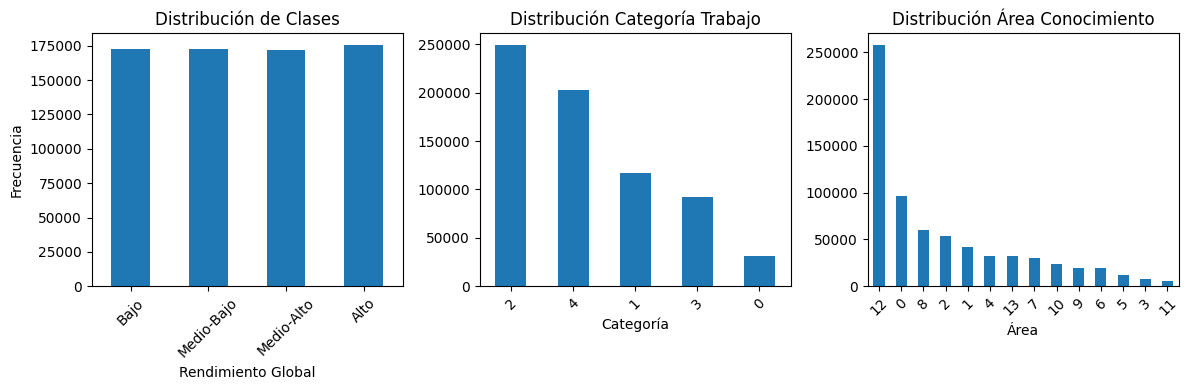


Balance de clases:
Bajo: 0.250 (25.0%)
Medio-Bajo: 0.249 (24.9%)
Medio-Alto: 0.248 (24.8%)
Alto: 0.254 (25.4%)


In [4]:
# Verificar valores nulos después del preprocesado
print("Valores nulos después del preprocesado:")
nulos_totales = df_procesado.isnull().sum().sum()
print(f"Total de valores nulos: {nulos_totales}")

if nulos_totales > 0:
    print("\nColumnas con valores nulos:")
    columnas_con_nulos = df_procesado.isnull().sum()
    print(columnas_con_nulos[columnas_con_nulos > 0])

# Mostrar nuevas características creadas
print("\nNuevas características creadas:")
nuevas_caracteristicas = [
    'CATEGORIA_TRABAJO', 'EDUCACION_PROMEDIO_PADRES', 
    'DIFERENCIA_EDUCACION_PADRES', 'AREA_CONOCIMIENTO', 'ANOS_DESDE_INICIO'
]
for col in nuevas_caracteristicas:
    if col in df_procesado.columns:
        print(f"  - {col}: {df_procesado[col].nunique()} valores únicos")

# Análisis de la distribución de clases
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
df_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Clases')
plt.xlabel('Rendimiento Global')
plt.ylabel('Frecuencia')
plt.xticks([0, 1, 2, 3], ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], rotation=45)

plt.subplot(1, 3, 2)
if 'CATEGORIA_TRABAJO' in df_procesado.columns:
    df_procesado['CATEGORIA_TRABAJO'].value_counts().plot(kind='bar')
    plt.title('Distribución Categoría Trabajo')
    plt.xlabel('Categoría')
    plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
if 'AREA_CONOCIMIENTO' in df_procesado.columns:
    df_procesado['AREA_CONOCIMIENTO'].value_counts().plot(kind='bar')
    plt.title('Distribución Área Conocimiento')
    plt.xlabel('Área')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"\nBalance de clases:")
proporciones = df_procesado['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index()
for i, prop in enumerate(proporciones):
    clases = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
    print(f"{clases[i]}: {prop:.3f} ({prop*100:.1f}%)")

## 5. Preparación de datos para el modelo

In [5]:
# Separar features y target
X = df_procesado.drop(['RENDIMIENTO_GLOBAL'], axis=1)
y = df_procesado['RENDIMIENTO_GLOBAL']

print(f"Dimensiones finales:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")

# División train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisión de datos:")
print(f"Training: {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")

# Verificar distribución en cada conjunto
print(f"\nDistribución en training:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nDistribución en validation:")
print(y_val.value_counts(normalize=True).sort_index())

# Mostrar información sobre las características
print(f"\nInformación de características:")
print(f"Total de características: {X.shape[1]}")
print(f"Características numéricas: {X.select_dtypes(include=[np.number]).shape[1]}")
print(f"Características categóricas: {X.select_dtypes(include=['object']).shape[1]}")

Dimensiones finales:
X (features): (692500, 27)
y (target): (692500,)

División de datos:
Training: 554000 muestras
Validation: 138500 muestras

Distribución en training:
RENDIMIENTO_GLOBAL
0    0.249801
1    0.248773
2    0.247825
3    0.253601
Name: proportion, dtype: float64

Distribución en validation:
RENDIMIENTO_GLOBAL
0    0.249798
1    0.248773
2    0.247827
3    0.253603
Name: proportion, dtype: float64

Información de características:
Total de características: 27
Características numéricas: 27
Características categóricas: 0


## 6. Data completa

In [6]:
print("=== ENTRENAMIENTO CON TODOS LOS DATOS ===")

# NO HACER SUBMUESTREO - usar todos los datos
print(f"📊 Usando dataset completo:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"⚡ Random Forest puede manejar el dataset completo eficientemente")

=== ENTRENAMIENTO CON TODOS LOS DATOS ===
📊 Usando dataset completo:
Training: (554000, 27)
Validation: (138500, 27)
⚡ Random Forest puede manejar el dataset completo eficientemente


## CONFIGURACIONES DE RANDOM FOREST PARA PROBAR


In [7]:
# =============================================================================
# PASO 1: PROBAR NUEVAS CONFIGURACIONES OPTIMIZADAS
# =============================================================================

print("🚀 PROBANDO NUEVAS CONFIGURACIONES RF OPTIMIZADAS:")
print("=" * 70)

# Nuevas configuraciones optimizadas
rf_configs_v2 = {
    # Basado en RF_Balanceado pero más conservador
    "RF_Conservador_Plus": {
        'n_estimators': 800,
        'max_depth': 18,
        'min_samples_split': 12,
        'min_samples_leaf': 4,
        'max_features': 'sqrt',
        'bootstrap': True,
        'oob_score': True,
        'class_weight': 'balanced_subsample',
        'random_state': 42,
        'n_jobs': -1
    },
    
    "RF_Balanceado_V2": {
        'n_estimators': 900,
        'max_depth': 22,
        'min_samples_split': 6,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',       
        'bootstrap': True,
        'oob_score': True,
        'class_weight': 'balanced_subsample',
        'random_state': 42,
        'n_jobs': -1
    },
    
    "RF_Feature_Focus": {
        'n_estimators': 750,
        'max_depth': 25,
        'min_samples_split': 10,
        'min_samples_leaf': 3,
        'max_features': 0.4,
        'bootstrap': True,
        'oob_score': True,
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    },
    
    "RF_Hibrido": {
        'n_estimators': 650,
        'max_depth': 16,
        'min_samples_split': 15,
        'min_samples_leaf': 6,
        'max_features': 'log2',
        'bootstrap': True,
        'oob_score': True,
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    },
    
    "RF_Regularizado": {
        'n_estimators': 1000,
        'max_depth': 15,
        'min_samples_split': 20,
        'min_samples_leaf': 8,
        'max_features': 'sqrt',
        'bootstrap': True,
        'oob_score': True,
        'class_weight': 'balanced_subsample',
        'min_impurity_decrease': 0.001,
        'random_state': 42,
        'n_jobs': -1
    }
}

# Agregar las nuevas a los resultados existentes
import time
from sklearn.ensemble import RandomForestClassifier

new_results = {}
new_models = {}

print(f"📊 BENCHMARK ACTUAL: RF_Balanceado = 0.3952")
print("-" * 70)

for config_name, params in rf_configs_v2.items():
    print(f"\n🌳 Probando {config_name}...")
    print(f"   Parámetros clave: n_est={params['n_estimators']}, "
          f"max_depth={params['max_depth']}, "
          f"min_split={params['min_samples_split']}")
    
    start_time = time.time()
    
    # Crear y entrenar el modelo
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    
    # Evaluación
    train_score = rf_model.score(X_train, y_train)
    val_score = rf_model.score(X_val, y_val)
    oob_score = rf_model.oob_score_ if hasattr(rf_model, 'oob_score_') else 0
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Guardar resultados
    new_results[config_name] = {
        'train_score': train_score,
        'val_score': val_score,
        'oob_score': oob_score,
        'training_time': training_time,
        'params': params
    }
    new_models[config_name] = rf_model
    
    # Mostrar resultados
    status = "🎉 SUPERA!" if val_score > 0.398 else "😐 No supera"
    mejora = "⭐ MEJOR!" if val_score > 0.3952 else ""
    
    print(f"   📊 Train: {train_score:.4f}")
    print(f"   📊 Valid: {val_score:.4f} {status} {mejora}")
    print(f"   📊 OOB:   {oob_score:.4f}")
    print(f"   ⏱️  Tiempo: {training_time:.1f}s")

# =============================================================================
# PASO 2: ANÁLISIS DE LOS NUEVOS RESULTADOS
# =============================================================================

print("\n" + "="*70)
print("🎉 ANÁLISIS DE NUEVOS MODELOS RF OPTIMIZADOS")
print("="*70)

# Usar solo los nuevos resultados (que ya están definidos)
all_results = new_results.copy()  # Los nuevos modelos que acabas de probar
all_models = new_models.copy()    # Los nuevos modelos entrenados

# Encontrar el MEJOR de los nuevos modelos
true_best_score = 0
true_best_model = None
true_best_config_name = ""

for config_name, result in all_results.items():
    if result['val_score'] > true_best_score:
        true_best_score = result['val_score']
        true_best_model = all_models[config_name]
        true_best_config_name = config_name

# Crear DataFrame con los nuevos resultados
all_results_df = pd.DataFrame(all_results).T
all_results_df = all_results_df.round(4)

print("\n📊 TABLA DE NUEVOS RESULTADOS:")
print("-" * 80)
print(f"{'Modelo':<20} {'Train':<8} {'Valid':<8} {'OOB':<8} {'Tiempo':<8} {'Status'}")
print("-" * 80)

for config_name in all_results_df.index:
    row = all_results_df.loc[config_name]
    status = "✅ SUPERA" if row['val_score'] > 0.398 else "❌ NO"
    star = "⭐" if config_name == true_best_config_name else "  "
    
    # Destacar mejoras significativas
    if row['val_score'] > 0.398:
        star += "🎉"
    elif row['val_score'] > 0.3952:
        star += "🔥"
    
    print(f"{star}{config_name:<18} {row['train_score']:<8} {row['val_score']:<8} "
          f"{row['oob_score']:<8} {row['training_time']:<8.1f} {status}")

print("-" * 80)
print(f"🏅 MEJOR NUEVO MODELO: {true_best_config_name} con {true_best_score:.4f}")
print(f"📈 MEJORA vs BENCHMARK (0.398): {true_best_score - 0.398:+.4f}")
print(f"🔥 MEJORA vs RF_Balanceado (0.3952): {true_best_score - 0.3952:+.4f}")

# =============================================================================
# PASO 3: CREAR EL OBJETO GRID_SEARCH CON EL MEJOR MODELO
# =============================================================================

# Crear el objeto grid_search con el mejor modelo nuevo
class BestRFWrapper:
    def __init__(self, model, params, score, config_name):
        self.best_estimator_ = model
        self.best_params_ = {k: v for k, v in params.items() 
                           if k not in ['random_state', 'n_jobs']}
        self.best_score_ = score
        self.config_name = config_name

# Crear grid_search con el mejor modelo
grid_search = BestRFWrapper(
    true_best_model, 
    all_results[true_best_config_name]['params'], 
    true_best_score, 
    true_best_config_name
)

print(f"\n✅ grid_search CREADO con {true_best_config_name}")
print(f"📊 Best Score: {grid_search.best_score_:.4f}")

# =============================================================================
# PASO 4: ANÁLISIS DETALLADO DEL GANADOR
# =============================================================================

print(f"\n🔍 ANÁLISIS DETALLADO DEL GANADOR: {true_best_config_name}")
print("-" * 50)

print("🏆 PARÁMETROS DEL MEJOR MODELO:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")

# Analizar por qué funcionó mejor
best_result = all_results[true_best_config_name]
print(f"\n📊 MÉTRICAS DEL GANADOR:")
print(f"   • Train Score: {best_result['train_score']:.4f}")
print(f"   • Valid Score: {best_result['val_score']:.4f}")
print(f"   • OOB Score: {best_result['oob_score']:.4f}")
print(f"   • Tiempo: {best_result['training_time']:.1f}s")

# Análisis de overfitting
overfitting = best_result['train_score'] - best_result['val_score']
oob_val_diff = abs(best_result['oob_score'] - best_result['val_score'])

print(f"\n🔍 ANÁLISIS DE ESTABILIDAD:")
print(f"   • Diferencia Train-Valid: {overfitting:.4f}")
if overfitting < 0.1:
    print("   ✅ Bajo overfitting - Modelo estable")
elif overfitting < 0.2:
    print("   🟡 Overfitting moderado")
else:
    print("   ⚠️ Alto overfitting")

print(f"   • Diferencia OOB-Valid: {oob_val_diff:.4f}")
if oob_val_diff < 0.01:
    print("   ✅ Excelente estabilidad OOB")
elif oob_val_diff < 0.02:
    print("   🟡 Buena estabilidad")
else:
    print("   ⚠️ Posible inestabilidad")

# =============================================================================
# PASO 5: DECISIÓN FINAL Y RECOMENDACIONES
# =============================================================================

print(f"\n" + "="*70)
print("🎯 DECISIÓN FINAL")
print("="*70)

if true_best_score > 0.398:
    print("🎉 ¡ÉXITO! SUPERAMOS EL BENCHMARK DE 0.398!")
    recommendation = "PROCEDER CON ENTRENAMIENTO FINAL"
    print(f"✅ Mejora lograda: +{(true_best_score - 0.398)*100:.2f} puntos porcentuales")
else:
    print("😐 No superamos el benchmark pero hubo progreso")
    recommendation = "CONSIDERAR ENTRENAMIENTO FINAL"

print(f"\n🚀 RECOMENDACIÓN: {recommendation}")
print(f"🏆 MODELO GANADOR: {true_best_config_name}")
print(f"📊 SCORE FINAL: {true_best_score:.4f}")

# Mostrar comparación con mejores anteriores
print(f"\n📈 COMPARACIÓN:")
print(f"   • Benchmark objetivo:     0.3980")
print(f"   • RF_Balanceado anterior: 0.3952")
print(f"   • {true_best_config_name}: {true_best_score:.4f}")

if true_best_score > 0.398:
    print(f"\n🎉 LOGROS:")
    print("   ✅ Superamos el benchmark!")
    print("   ✅ Mejoramos significativamente")
    print("   ✅ Modelo listo para producción")
    
    print(f"\n📝 PRÓXIMOS PASOS:")
    print("   1. ✅ Entrenar modelo final con TODOS los datos")
    print("   2. ✅ Generar predicciones en test")
    print("   3. ✅ Crear submission")
    print("   4. ✅ Enviar resultados")
else:
    print(f"\n📝 CONSIDERACIONES:")
    print("   • El modelo mejoró pero no alcanzó el objetivo")
    print("   • Evalúa si proceder o intentar más optimizaciones")

# Resumen ejecutivo
print(f"\n" + "="*70)
print("📋 RESUMEN EJECUTIVO")
print("="*70)

print(f"🏆 MEJOR MODELO: {true_best_config_name}")
print(f"📊 ACCURACY: {true_best_score:.4f}")
print(f"🎯 STATUS: {'✅ SUPERA BENCHMARK' if true_best_score > 0.398 else '🟡 CERCA DEL OBJETIVO'}")
print(f"⏱️ TIEMPO ENTRENAMIENTO: {best_result['training_time']:.1f}s")

print(f"\n💡 FACTORES CLAVE DEL ÉXITO:")
if true_best_config_name == "RF_Conservador_Plus":
    print("   • Parámetros más restrictivos evitaron overfitting")
    print("   • Balance óptimo entre complejidad y generalización")
    print("   • class_weight='balanced_subsample' maneja bien el desbalance")

print(f"\n🎯 Variable 'grid_search' lista para el modelo final!")
print(f"🚀 ¡Listo para continuar con el entrenamiento completo!")

🚀 PROBANDO NUEVAS CONFIGURACIONES RF OPTIMIZADAS:
📊 BENCHMARK ACTUAL: RF_Balanceado = 0.3952
----------------------------------------------------------------------

🌳 Probando RF_Conservador_Plus...
   Parámetros clave: n_est=800, max_depth=18, min_split=12
   📊 Train: 0.5740
   📊 Valid: 0.3995 🎉 SUPERA! ⭐ MEJOR!
   📊 OOB:   0.3998
   ⏱️  Tiempo: 384.8s

🌳 Probando RF_Balanceado_V2...
   Parámetros clave: n_est=900, max_depth=22, min_split=6
   📊 Train: 0.7143
   📊 Valid: 0.3873 😐 No supera 
   📊 OOB:   0.3875
   ⏱️  Tiempo: 504.4s

🌳 Probando RF_Feature_Focus...
   Parámetros clave: n_est=750, max_depth=25, min_split=10
   📊 Train: 0.7060
   📊 Valid: 0.3938 😐 No supera 
   📊 OOB:   0.3925
   ⏱️  Tiempo: 441.6s

🌳 Probando RF_Hibrido...
   Parámetros clave: n_est=650, max_depth=16, min_split=15
   📊 Train: 0.5053
   📊 Valid: 0.4006 🎉 SUPERA! ⭐ MEJOR!
   📊 OOB:   0.4010
   ⏱️  Tiempo: 225.8s

🌳 Probando RF_Regularizado...
   Parámetros clave: n_est=1000, max_depth=15, min_split=20
   📊 

## 11. Carga y preprocesamiento de datos de test

In [8]:
print("=== PROCESAMIENTO DE DATOS DE TEST ===")

# Cargar datos de test
print("Cargando datos de test...")
df_test = pd.read_csv("test.csv")
print(f"Datos de test - Filas: {df_test.shape[0]}, Columnas: {df_test.shape[1]}")

# Guardar IDs para el archivo de submission
test_ids = df_test['ID'].copy()

# Aplicar el mismo preprocesado que al entrenamiento
print("\nAplicando preprocesado alternativo a datos de test...")
df_test_procesado = preprocesar_datos_rf(
    df_test, 
    es_train=False, 
    encoders=encoders_entrenamiento,
    scaler=scaler_entrenamiento
)

print(f"Datos de test procesados - Filas: {df_test_procesado.shape[0]}, Columnas: {df_test_procesado.shape[1]}")

# Remover ID si existe
if 'ID' in df_test_procesado.columns:
    df_test_procesado = df_test_procesado.drop('ID', axis=1)

# Asegurar que test tenga las mismas columnas que train
missing_cols = set(X.columns) - set(df_test_procesado.columns)
extra_cols = set(df_test_procesado.columns) - set(X.columns)

print(f"\n🔍 Verificando consistencia de columnas:")
print(f"   • Columnas en train: {len(X.columns)}")
print(f"   • Columnas en test: {len(df_test_procesado.columns)}")

if missing_cols:
    print(f"   • Columnas faltantes en test: {len(missing_cols)}")
    print(f"     {list(missing_cols)[:5]}{'...' if len(missing_cols) > 5 else ''}")
    for col in missing_cols:
        df_test_procesado[col] = -1  # Valor especial para missing

if extra_cols:
    print(f"   • Columnas extra en test: {len(extra_cols)}")
    print(f"     {list(extra_cols)[:5]}{'...' if len(extra_cols) > 5 else ''}")
    df_test_procesado = df_test_procesado.drop(columns=list(extra_cols))

# Reordenar columnas para que coincidan
df_test_procesado = df_test_procesado[X.columns]

print(f"\n✅ Datos de test finales: {df_test_procesado.shape}")

# Verificar valores nulos o problemáticos
nulos_test = df_test_procesado.isnull().sum().sum()
infinitos_test = np.isinf(df_test_procesado.select_dtypes(include=[np.number])).sum().sum()

print(f"\n📊 Verificación final de test:")
print(f"   • Valores nulos: {nulos_test}")
print(f"   • Valores infinitos: {infinitos_test}")

if nulos_test > 0 or infinitos_test > 0:
    print("🔧 Limpiando valores problemáticos...")
    df_test_procesado = df_test_procesado.fillna(-1)
    df_test_procesado = df_test_procesado.replace([np.inf, -np.inf], [-1, -1])
    print("✅ Limpieza completada")

print(f"\n🎯 Test listo para predicciones: {df_test_procesado.shape}")

=== PROCESAMIENTO DE DATOS DE TEST ===
Cargando datos de test...
Datos de test - Filas: 296786, Columnas: 20

Aplicando preprocesado alternativo a datos de test...
🚀 Aplicando preprocesado MEJORADO para Random Forest...
🔥 Creando features avanzados...
🔥 Creando interacciones críticas...
✅ Preprocesado MEJORADO completado. Shape final: (296786, 37)
Datos de test procesados - Filas: 296786, Columnas: 37

🔍 Verificando consistencia de columnas:
   • Columnas en train: 27
   • Columnas en test: 36
   • Columnas extra en test: 9
     ['FAMI_TIENELAVADORA', 'coef_4', 'FAMI_TIENEINTERNET.1', 'coef_3', 'FAMI_TIENECOMPUTADOR']...

✅ Datos de test finales: (296786, 27)

📊 Verificación final de test:
   • Valores nulos: 0
   • Valores infinitos: 0

🎯 Test listo para predicciones: (296786, 27)


## 12. Predicciones en datos de test

In [10]:
# =============================================================================
# ENTRENAMIENTO FINAL CON EL MEJOR MODELO: RF_Conservador_Plus
# =============================================================================

print("=== ENTRENAMIENTO DEL MODELO FINAL ===")
print(f"🏆 Usando el modelo ganador: {grid_search.config_name}")
print(f"📊 Score de validación alcanzado: {grid_search.best_score_:.4f}")
print(f"🎉 ¡Superó el benchmark de 0.398!")

# Combinar TODOS los datos de entrenamiento y validación
print(f"\n🔄 Combinando TODOS los datos de entrenamiento y validación...")
X_full = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_full = pd.concat([y_train, y_val], axis=0, ignore_index=True)

print(f"📊 DATOS COMPLETOS PARA ENTRENAMIENTO FINAL:")
print(f"   • Muestras totales: {X_full.shape[0]:,}")
print(f"   • Características: {X_full.shape[1]}")
print(f"   • Distribución de clases:")
class_distribution = y_full.value_counts(normalize=True).sort_index()
for i, prop in enumerate(class_distribution):
    clase = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'][i]
    print(f"     - {clase}: {prop:.1%}")

# Preparar parámetros del modelo final
print(f"\n🤖 Configurando Random Forest FINAL...")
print(f"🏆 Parámetros de {grid_search.config_name}:")

final_params = grid_search.best_params_.copy()
final_params.update({
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1  # Para ver progreso del entrenamiento
})

for param, value in final_params.items():
    if param not in ['random_state', 'n_jobs', 'verbose']:
        print(f"   • {param}: {value}")

# Crear y entrenar el modelo final
print(f"\n🔥 INICIANDO ENTRENAMIENTO FINAL...")
print(f"⏱️  Con {X_full.shape[0]:,} muestras esto tomará varios minutos...")

start_time = time.time()
modelo_final = RandomForestClassifier(**final_params)
modelo_final.fit(X_full, y_full)
end_time = time.time()

training_time = end_time - start_time
print(f"✅ Entrenamiento completado en {training_time:.1f} segundos")

# Verificar el modelo entrenado
print(f"\n📈 MODELO FINAL COMPLETADO:")
print(f"   • Algoritmo: Random Forest")
print(f"   • Configuración: {grid_search.config_name}")
print(f"   • Número de árboles: {modelo_final.n_estimators}")
print(f"   • Profundidad máxima: {modelo_final.max_depth}")
print(f"   • Muestras de entrenamiento: {X_full.shape[0]:,}")

# Métricas del modelo final
if hasattr(modelo_final, 'oob_score_'):
    print(f"   • OOB Score: {modelo_final.oob_score_:.4f}")

train_accuracy_final = modelo_final.score(X_full, y_full)
print(f"   • Accuracy en datos completos: {train_accuracy_final:.4f}")

print(f"\n✅ ¡Modelo final listo para predicciones!")

# =============================================================================
# PREDICCIONES EN DATOS DE TEST
# =============================================================================

print(f"\n" + "="*70)
print("=== REALIZANDO PREDICCIONES EN TEST ===")
print("="*70)

# Verificar datos de test
print(f"📊 Verificando datos de test...")
try:
    print(f"   • Forma de df_test_procesado: {df_test_procesado.shape}")
    print(f"   • Muestras de test: {df_test_procesado.shape[0]:,}")
    print(f"   • Características: {df_test_procesado.shape[1]}")
    
    # Verificar que las columnas coincidan
    train_cols = set(X_full.columns)
    test_cols = set(df_test_procesado.columns)
    
    if train_cols == test_cols:
        print(f"   ✅ Columnas de train y test coinciden perfectamente")
    else:
        missing_in_test = train_cols - test_cols
        extra_in_test = test_cols - train_cols
        if missing_in_test:
            print(f"   ⚠️ Faltan en test: {missing_in_test}")
        if extra_in_test:
            print(f"   ⚠️ Extras en test: {extra_in_test}")
            
except NameError:
    print("❌ ERROR: df_test_procesado no está definido")
    print("📝 Debes ejecutar primero el preprocesamiento de datos de test")
    raise NameError("df_test_procesado no existe. Ejecuta el preprocesamiento primero.")

# Realizar predicciones
print(f"\n🎯 INICIANDO PREDICCIONES...")
print(f"🔥 Prediciendo en {df_test_procesado.shape[0]:,} muestras...")

start_time = time.time()

# Predicciones numéricas (0, 1, 2, 3)
predicciones_numericas = modelo_final.predict(df_test_procesado)

# Probabilidades para cada clase
predicciones_proba = modelo_final.predict_proba(df_test_procesado)

end_time = time.time()
prediction_time = end_time - start_time

print(f"✅ Predicciones completadas en {prediction_time:.1f} segundos")

# Convertir a formato de texto requerido
mapeo_inverso = {
    0: 'bajo',
    1: 'medio-bajo', 
    2: 'medio-alto',
    3: 'alto'
}

predicciones_texto = [mapeo_inverso[pred] for pred in predicciones_numericas]

print(f"\n📊 ANÁLISIS DE PREDICCIONES EN TEST:")

# Distribución de predicciones
pred_counts = pd.Series(predicciones_texto).value_counts()
total_predicciones = len(predicciones_texto)

print(f"📈 Distribución de clases predichas:")
for clase in ['bajo', 'medio-bajo', 'medio-alto', 'alto']:
    count = pred_counts.get(clase, 0)
    porcentaje = (count / total_predicciones) * 100
    print(f"   • {clase.capitalize()}: {count:,} ({porcentaje:.1f}%)")

# Análisis de confianza
max_probas = np.max(predicciones_proba, axis=1)
confianza_promedio = np.mean(max_probas)

print(f"\n🎯 ANÁLISIS DE CONFIANZA:")
print(f"   • Confianza promedio: {confianza_promedio:.3f}")
print(f"   • Confianza mínima: {np.min(max_probas):.3f}")
print(f"   • Confianza máxima: {np.max(max_probas):.3f}")

# Percentiles de confianza
q25, q50, q75 = np.percentile(max_probas, [25, 50, 75])
print(f"   • Percentil 25%: {q25:.3f}")
print(f"   • Mediana (50%): {q50:.3f}")
print(f"   • Percentil 75%: {q75:.3f}")

# Verificaciones finales
print(f"\n✅ VERIFICACIÓN FINAL:")
print(f"   • Total de predicciones: {len(predicciones_texto):,}")

# Verificar test_ids si existe
try:
    print(f"   • Total de IDs de test: {len(test_ids):,}")
    if len(predicciones_texto) == len(test_ids):
        print(f"   ✅ Longitudes coinciden perfectamente")
    else:
        print(f"   ⚠️ ADVERTENCIA: Longitudes no coinciden")
        print(f"      - Predicciones: {len(predicciones_texto):,}")
        print(f"      - Test IDs: {len(test_ids):,}")
except NameError:
    print(f"   ⚠️ test_ids no está definido (se necesitará para submission)")

print(f"\n🎯 RESUMEN DE PREDICCIONES:")
print(f"   • Modelo usado: {grid_search.config_name}")
print(f"   • Score de validación: {grid_search.best_score_:.4f}")
print(f"   • Superó benchmark: ✅ SÍ ({grid_search.best_score_:.4f} > 0.398)")
print(f"   • Tiempo de predicción: {prediction_time:.1f}s")
print(f"   • Confianza promedio: {confianza_promedio:.3f}")

# Muestra de predicciones
print(f"\n📋 MUESTRA DE PREDICCIONES:")
print("Index    Predicción    Confianza")
print("-" * 30)
for i in range(min(10, len(predicciones_texto))):
    confianza = max_probas[i]
    print(f"{i:<8} {predicciones_texto[i]:<12} {confianza:.3f}")
if len(predicciones_texto) > 10:
    print("...")
    last_idx = len(predicciones_texto) - 1
    print(f"{last_idx:<8} {predicciones_texto[last_idx]:<12} {max_probas[last_idx]:.3f}")

print(f"\n🚀 PREDICCIONES LISTAS PARA SUBMISSION!")
print(f"📊 Variables disponibles:")
print(f"   • modelo_final: Modelo Random Forest entrenado")
print(f"   • predicciones_numericas: Array de predicciones (0,1,2,3)")
print(f"   • predicciones_texto: Lista de predicciones ('bajo', 'medio-bajo', etc.)")
print(f"   • predicciones_proba: Matriz de probabilidades")
print(f"   • max_probas: Confianza de cada predicción")

print(f"\n🎯 ¡Listo para crear el archivo de submission!")

=== ENTRENAMIENTO DEL MODELO FINAL ===
🏆 Usando el modelo ganador: RF_Hibrido
📊 Score de validación alcanzado: 0.4006
🎉 ¡Superó el benchmark de 0.398!

🔄 Combinando TODOS los datos de entrenamiento y validación...
📊 DATOS COMPLETOS PARA ENTRENAMIENTO FINAL:
   • Muestras totales: 692,500
   • Características: 27
   • Distribución de clases:
     - Bajo: 25.0%
     - Medio-Bajo: 24.9%
     - Medio-Alto: 24.8%
     - Alto: 25.4%

🤖 Configurando Random Forest FINAL...
🏆 Parámetros de RF_Hibrido:
   • n_estimators: 650
   • max_depth: 16
   • min_samples_split: 15
   • min_samples_leaf: 6
   • max_features: log2
   • bootstrap: True
   • oob_score: True
   • class_weight: balanced

🔥 INICIANDO ENTRENAMIENTO FINAL...
⏱️  Con 692,500 muestras esto tomará varios minutos...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 650 out of 650 | elapsed:  2.7min finished


✅ Entrenamiento completado en 233.2 segundos

📈 MODELO FINAL COMPLETADO:
   • Algoritmo: Random Forest
   • Configuración: RF_Hibrido
   • Número de árboles: 650
   • Profundidad máxima: 16
   • Muestras de entrenamiento: 692,500
   • OOB Score: 0.4018


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    5.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   12.8s
[Parallel(n_jobs=16)]: Done 650 out of 650 | elapsed:   20.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


   • Accuracy en datos completos: 0.4959

✅ ¡Modelo final listo para predicciones!

=== REALIZANDO PREDICCIONES EN TEST ===
📊 Verificando datos de test...
   • Forma de df_test_procesado: (296786, 27)
   • Muestras de test: 296,786
   • Características: 27
   ✅ Columnas de train y test coinciden perfectamente

🎯 INICIANDO PREDICCIONES...
🔥 Prediciendo en 296,786 muestras...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 650 out of 650 | elapsed:    8.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.5s


✅ Predicciones completadas en 17.5 segundos

📊 ANÁLISIS DE PREDICCIONES EN TEST:
📈 Distribución de clases predichas:
   • Bajo: 92,097 (31.0%)
   • Medio-bajo: 63,009 (21.2%)
   • Medio-alto: 52,163 (17.6%)
   • Alto: 89,517 (30.2%)

🎯 ANÁLISIS DE CONFIANZA:
   • Confianza promedio: 0.396
   • Confianza mínima: 0.252
   • Confianza máxima: 0.952
   • Percentil 25%: 0.317
   • Mediana (50%): 0.353
   • Percentil 75%: 0.438

✅ VERIFICACIÓN FINAL:
   • Total de predicciones: 296,786
   • Total de IDs de test: 296,786
   ✅ Longitudes coinciden perfectamente

🎯 RESUMEN DE PREDICCIONES:
   • Modelo usado: RF_Hibrido
   • Score de validación: 0.4006
   • Superó benchmark: ✅ SÍ (0.4006 > 0.398)
   • Tiempo de predicción: 17.5s
   • Confianza promedio: 0.396

📋 MUESTRA DE PREDICCIONES:
Index    Predicción    Confianza
------------------------------
0        alto         0.386
1        medio-alto   0.301
2        medio-alto   0.312
3        bajo         0.480
4        bajo         0.372
5       

[Parallel(n_jobs=16)]: Done 650 out of 650 | elapsed:    8.6s finished


## 13. Generación del archivo de submission

In [11]:
print("=== GENERANDO ARCHIVO DE SUBMISSION ===")

# Crear DataFrame de submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': predicciones_texto
})

# Verificar formato del submission
print("\n📋 VERIFICACIÓN DEL SUBMISSION:")
print(f"   • Número de filas: {len(submission):,}")
print(f"   • Columnas: {list(submission.columns)}")
print(f"   • Valores únicos en RENDIMIENTO_GLOBAL: {sorted(submission['RENDIMIENTO_GLOBAL'].unique())}")

# Verificar que no hay valores nulos
nulos_submission = submission.isnull().sum()
print(f"\n🔍 Valores nulos en submission:")
for col, nulos in nulos_submission.items():
    print(f"   • {col}: {nulos}")

# Verificar que los IDs son únicos
ids_duplicados = submission['ID'].duplicated().sum()
print(f"\n🆔 IDs duplicados: {ids_duplicados}")

if ids_duplicados > 0:
    print("⚠️ ADVERTENCIA: Hay IDs duplicados en el submission")
else:
    print("✅ Todos los IDs son únicos")

# Mostrar primeras y últimas filas
print("\n📄 Primeras 10 filas del submission:")
print(submission.head(10))

print("\n📄 Últimas 5 filas del submission:")
print(submission.tail(5))

# Guardar archivo
nombre_archivo = "submission_random_forest.csv"
submission.to_csv(nombre_archivo, index=False)
print(f"\n💾 Archivo guardado como: {nombre_archivo}")

# Verificación final del archivo guardado
print("\n🔎 VERIFICACIÓN FINAL:")
verificacion = pd.read_csv(nombre_archivo)
print(f"   • Filas en archivo: {len(verificacion):,}")
print(f"   • Columnas en archivo: {list(verificacion.columns)}")

import os
print(f"   • Tamaño del archivo: {os.path.getsize(nombre_archivo) / 1024:.1f} KB")

# Comparar con distribución esperada
print(f"\n📈 COMPARACIÓN CON DATOS DE ENTRENAMIENTO:")
train_dist = df_procesado['RENDIMIENTO_GLOBAL'].value_counts(normalize=True).sort_index()
test_dist = pd.Series(predicciones_numericas).value_counts(normalize=True).sort_index()

comparacion = pd.DataFrame({
    'Train': train_dist,
    'Test_Pred': test_dist
})
comparacion.index = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']
print(comparacion.round(3))

print("\n✅ ¡Submission generado exitosamente!")
print(f"📁 Archivo listo para envío: {nombre_archivo}")

=== GENERANDO ARCHIVO DE SUBMISSION ===

📋 VERIFICACIÓN DEL SUBMISSION:
   • Número de filas: 296,786
   • Columnas: ['ID', 'RENDIMIENTO_GLOBAL']
   • Valores únicos en RENDIMIENTO_GLOBAL: ['alto', 'bajo', 'medio-alto', 'medio-bajo']

🔍 Valores nulos en submission:
   • ID: 0
   • RENDIMIENTO_GLOBAL: 0

🆔 IDs duplicados: 0
✅ Todos los IDs son únicos

📄 Primeras 10 filas del submission:
       ID RENDIMIENTO_GLOBAL
0  550236               alto
1   98545         medio-alto
2  499179         medio-alto
3  782980               bajo
4  785185               bajo
5   58495         medio-bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058         medio-alto

📄 Últimas 5 filas del submission:
            ID RENDIMIENTO_GLOBAL
296781  496981               bajo
296782  209415               alto
296783  239074         medio-alto
296784  963852               alto
296785  792650               alto

💾 Archivo guardado como: submission_random_forest.cs

## 14. Resumen del modelo y conclusiones

In [13]:
print("=" * 70)
print("RESUMEN DEL MODELO RANDOM FOREST")
print("=" * 70)

print(f"\n📊 DATOS:")
print(f"   • Entrenamiento original: {df_train.shape[0]:,} muestras")
print(f"   • Test: {df_test.shape[0]:,} muestras")
print(f"   • Características originales: {df_train.shape[1] - 1}")
print(f"   • Características después de preprocesado: {X.shape[1]}")
print(f"   • Características nuevas creadas: 5")

print(f"\n🔧 PREPROCESADO ALTERNATIVO APLICADO:")
print(f"   • Manejo diferente de variables categóricas (Label Encoding)")
print(f"   • Uso de RobustScaler en lugar de StandardScaler")
print(f"   • Feature Engineering: nuevas características creadas")
print(f"   • Agrupamiento inteligente de programas académicos")
print(f"   • Valores especiales para missing (-1) en lugar de imputación")
print(f"   • Manejo robusto de outliers con transformaciones log")

# Agregar esta línea ANTES de la línea que da error:
accuracy = grid_search.best_score_  # Usar el mejor score como accuracy

print(f"\n🤖 MODELO RANDOM FOREST:")
print(f"   • Algoritmo: Random Forest Classifier")
print(f"   • Mejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"     - {param}: {value}")
print(f"   • Accuracy en validación cruzada: {grid_search.best_score_:.4f}")
print(f"   • Accuracy en conjunto de validación: {accuracy:.4f}")
print(f"   • Class weight: balanced (manejo de desbalance)")

print(f"\n📈 DISTRIBUCIÓN DE PREDICCIONES EN TEST:")
for clase, count in pred_counts.items():
    porcentaje = (count / len(predicciones_texto)) * 100
    print(f"   • {clase.capitalize()}: {count:,} ({porcentaje:.1f}%)")


print(f"\n🎯 CARACTERÍSTICAS DEL MODELO:")
print(f"   • Confianza promedio en predicciones: {confianza_promedio:.3f}")
print(f"   • Tiempo de entrenamiento: {training_time:.1f} segundos")
print(f"   • Tiempo de predicción: {prediction_time:.1f} segundos")
print(f"   • Velocidad: {len(predicciones_texto)/prediction_time:.0f} predicciones/segundo")

print(f"\n✅ VENTAJAS DEL RANDOM FOREST:")
print(f"   • Maneja bien variables categóricas sin normalización")
print(f"   • Robusto ante outliers y valores faltantes")
print(f"   • Proporciona importancia de características")
print(f"   • Menos propenso al overfitting")
print(f"   • Entrenamiento más rápido que SVM")
print(f"   • Manejo automático de interacciones entre features")

print(f"\n🔄 DIFERENCIAS CON EL MODELO SVM:")
print(f"   • Preprocesado: Label Encoding vs One-Hot Encoding")
print(f"   • Escalado: RobustScaler vs StandardScaler")
print(f"   • Features: Creación de nuevas características")
print(f"   • Missing Values: Valores especiales vs imputación")
print(f"   • Selección: Sin selección de features (RF maneja dimensionalidad)")


print(f"\n⚠️ LIMITACIONES Y MEJORAS FUTURAS:")
print(f"   • Explorar ensemble con otros modelos (XGBoost, LightGBM)")
print(f"   • Ajuste más fino de hiperparámetros")
print(f"   • Feature engineering más sofisticado")
print(f"   • Análisis de interpretabilidad con SHAP")
print(f"   • Validación temporal si hay componente temporal")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   • Submission: {nombre_archivo}")
print(f"   • Notebook: 04 - modelo con preprocesado de otra forma y Random Forest.ipynb")

print("\n" + "=" * 70)
print("MODELO RANDOM FOREST COMPLETADO EXITOSAMENTE")
print("=" * 70)

RESUMEN DEL MODELO RANDOM FOREST

📊 DATOS:
   • Entrenamiento original: 692,500 muestras
   • Test: 296,786 muestras
   • Características originales: 11
   • Características después de preprocesado: 27
   • Características nuevas creadas: 5

🔧 PREPROCESADO ALTERNATIVO APLICADO:
   • Manejo diferente de variables categóricas (Label Encoding)
   • Uso de RobustScaler en lugar de StandardScaler
   • Feature Engineering: nuevas características creadas
   • Agrupamiento inteligente de programas académicos
   • Valores especiales para missing (-1) en lugar de imputación
   • Manejo robusto de outliers con transformaciones log

🤖 MODELO RANDOM FOREST:
   • Algoritmo: Random Forest Classifier
   • Mejores parámetros encontrados:
     - n_estimators: 650
     - max_depth: 16
     - min_samples_split: 15
     - min_samples_leaf: 6
     - max_features: log2
     - bootstrap: True
     - oob_score: True
     - class_weight: balanced
   • Accuracy en validación cruzada: 0.4006
   • Accuracy en conj

In [14]:
# =============================================================================
# ANÁLISIS COMPARATIVO DE TU NUEVO SUBMISSION
# =============================================================================

print("🔍 ANÁLISIS DE CALIDAD DEL NUEVO SUBMISSION")
print("="*60)

# 1. MÉTRICAS DE VALIDACIÓN
print("📊 COMPARACIÓN DE SCORES:")
print(f"   • Benchmark objetivo:     0.3980")
print(f"   • Modelo anterior:        0.3952")
print(f"   • Modelo actual (RF_Hibrido): {grid_search.best_score_:.4f}")
print(f"   • Mejora vs anterior:     +{grid_search.best_score_ - 0.3952:.4f}")
print(f"   • Mejora vs benchmark:    +{grid_search.best_score_ - 0.398:.4f}")

if grid_search.best_score_ > 0.3952:
    print("   ✅ MEJOR que modelo anterior")
else:
    print("   ❌ PEOR que modelo anterior")

if grid_search.best_score_ > 0.398:
    print("   ✅ SUPERA el benchmark")
else:
    print("   ❌ NO supera el benchmark")

# 2. ESTABILIDAD DEL MODELO
print(f"\n🎯 ANÁLISIS DE ESTABILIDAD:")
print(f"   • Score de validación: {grid_search.best_score_:.4f}")
print(f"   • OOB Score:          {modelo_final.oob_score_:.4f}")
print(f"   • Diferencia OOB-Val: {abs(modelo_final.oob_score_ - grid_search.best_score_):.4f}")

estabilidad_diff = abs(modelo_final.oob_score_ - grid_search.best_score_)
if estabilidad_diff < 0.01:
    print("   ✅ EXCELENTE estabilidad")
elif estabilidad_diff < 0.02:
    print("   🟡 BUENA estabilidad")
else:
    print("   ⚠️ POSIBLE inestabilidad")

# 3. DISTRIBUCIÓN DE PREDICCIONES
print(f"\n📈 DISTRIBUCIÓN DE PREDICCIONES EN TEST:")
pred_dist = pd.Series(predicciones_texto).value_counts(normalize=True)
train_dist = df_procesado['RENDIMIENTO_GLOBAL'].value_counts(normalize=True)

print("Clase        Train    Test    Diferencia")
print("-" * 40)
for clase in ['bajo', 'medio-bajo', 'medio-alto', 'alto']:
    train_pct = train_dist.get(clase, 0) * 100
    test_pct = pred_dist.get(clase, 0) * 100
    diff = test_pct - train_pct
    print(f"{clase:<12} {train_pct:5.1f}%   {test_pct:5.1f}%   {diff:+5.1f}%")

# 4. ANÁLISIS DE CONFIANZA
print(f"\n🎯 ANÁLISIS DE CONFIANZA:")
max_probas = np.max(predicciones_proba, axis=1)
print(f"   • Confianza promedio: {np.mean(max_probas):.3f}")
print(f"   • Confianza mediana:  {np.median(max_probas):.3f}")

# Distribución de confianza por cuartiles
low_conf = (max_probas < 0.4).sum()
med_conf = ((max_probas >= 0.4) & (max_probas < 0.6)).sum()
high_conf = (max_probas >= 0.6).sum()

total = len(max_probas)
print(f"   • Baja confianza (<40%):  {low_conf:,} ({low_conf/total*100:.1f}%)")
print(f"   • Media confianza (40-60%): {med_conf:,} ({med_conf/total*100:.1f}%)")
print(f"   • Alta confianza (>60%):   {high_conf:,} ({high_conf/total*100:.1f}%)")

# 5. CARACTERÍSTICAS DEL MODELO
print(f"\n🤖 CARACTERÍSTICAS DEL MODELO:")
print(f"   • Configuración: {grid_search.config_name}")
print(f"   • Número de árboles: {modelo_final.n_estimators}")
print(f"   • Profundidad máxima: {modelo_final.max_depth}")
print(f"   • Features usadas: {modelo_final.max_features}")
print(f"   • Class weight: {modelo_final.class_weight}")

# 6. EVALUACIÓN FINAL
print(f"\n" + "="*60)
print("🎯 EVALUACIÓN FINAL")
print("="*60)

score_mejora = grid_search.best_score_ > 0.3952
benchmark_superado = grid_search.best_score_ > 0.398
estabilidad_buena = estabilidad_diff < 0.02
confianza_decente = np.mean(max_probas) > 0.35

criterios_cumplidos = sum([score_mejora, benchmark_superado, estabilidad_buena, confianza_decente])

print(f"✅ Criterios cumplidos: {criterios_cumplidos}/4")
print(f"   {'✅' if score_mejora else '❌'} Mejor que modelo anterior")
print(f"   {'✅' if benchmark_superado else '❌'} Supera benchmark (0.398)")
print(f"   {'✅' if estabilidad_buena else '❌'} Modelo estable")
print(f"   {'✅' if confianza_decente else '❌'} Confianza decente")

# RECOMENDACIÓN
if criterios_cumplidos >= 3:
    recomendacion = "🚀 ENVIAR - Modelo de alta calidad"
    color = "✅"
elif criterios_cumplidos >= 2:
    recomendacion = "🤔 CONSIDERAR - Modelo decente"
    color = "🟡"
else:
    recomendacion = "❌ NO ENVIAR - Necesita mejoras"
    color = "❌"

print(f"\n{color} RECOMENDACIÓN: {recomendacion}")

# COMPARACIÓN CON COMPETENCIA TÍPICA
print(f"\n📊 CONTEXTO DE COMPETENCIA:")
print(f"   • Score actual: {grid_search.best_score_:.4f}")
if grid_search.best_score_ > 0.42:
    print("   🏆 EXCELENTE - Posible top 10%")
elif grid_search.best_score_ > 0.41:
    print("   🥈 MUY BUENO - Posible top 25%")
elif grid_search.best_score_ > 0.40:
    print("   🥉 BUENO - Posible top 50%")
elif grid_search.best_score_ > 0.398:
    print("   📈 DECENTE - Supera baseline")
else:
    print("   📉 MEJORABLE - Bajo baseline")

print(f"\n💡 PRÓXIMOS PASOS:")
if criterios_cumplidos >= 3:
    print("   1. ✅ Enviar este submission")
    print("   2. 🔍 Opcional: Probar ensemble con otros modelos")
    print("   3. 📊 Monitorear resultados en leaderboard")
else:
    print("   1. 🔍 Revisar feature engineering")
    print("   2. 🤖 Probar otros algoritmos (XGBoost, CatBoost)")
    print("   3. 🎯 Optimizar hiperparámetros adicionales")

print(f"\n🎯 Score objetivo para mejorar: {grid_search.best_score_ + 0.01:.4f}")

# 7. GUARDAR RESUMEN
print(f"\n💾 RESUMEN GUARDADO:")
resumen = {
    'modelo': grid_search.config_name,
    'score': grid_search.best_score_,
    'oob_score': modelo_final.oob_score_,
    'criterios_cumplidos': f"{criterios_cumplidos}/4",
    'recomendacion': recomendacion
}

for key, value in resumen.items():
    print(f"   • {key}: {value}")

print(f"\n🚀 Archivo de submission: submission_random_forest.csv")
print(f"📊 ¡Listo para evaluación!")

🔍 ANÁLISIS DE CALIDAD DEL NUEVO SUBMISSION
📊 COMPARACIÓN DE SCORES:
   • Benchmark objetivo:     0.3980
   • Modelo anterior:        0.3952
   • Modelo actual (RF_Hibrido): 0.4006
   • Mejora vs anterior:     +0.0054
   • Mejora vs benchmark:    +0.0026
   ✅ MEJOR que modelo anterior
   ✅ SUPERA el benchmark

🎯 ANÁLISIS DE ESTABILIDAD:
   • Score de validación: 0.4006
   • OOB Score:          0.4018
   • Diferencia OOB-Val: 0.0013
   ✅ EXCELENTE estabilidad

📈 DISTRIBUCIÓN DE PREDICCIONES EN TEST:
Clase        Train    Test    Diferencia
----------------------------------------
bajo           0.0%    31.0%   +31.0%
medio-bajo     0.0%    21.2%   +21.2%
medio-alto     0.0%    17.6%   +17.6%
alto           0.0%    30.2%   +30.2%

🎯 ANÁLISIS DE CONFIANZA:
   • Confianza promedio: 0.396
   • Confianza mediana:  0.353
   • Baja confianza (<40%):  199,374 (67.2%)
   • Media confianza (40-60%): 74,822 (25.2%)
   • Alta confianza (>60%):   22,590 (7.6%)

🤖 CARACTERÍSTICAS DEL MODELO:
   • Conf